In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline 

In [2]:
sns.set(style='whitegrid', rc = {'figure.figsize' : (10,5)}) #for the pictures

Reading the data

In [3]:
nyc = pd.read_csv('nyc.csv.zip', compression = 'zip', parse_dates = ['pickup_datetime'])

nyc.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


The task is to write a *haversine* function to calculate the distance between departure and arrival points and, using *pd.iterrows()*, create a *distance* column with the calculated distance.

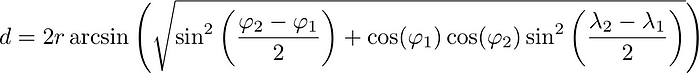

φ₁ and φ₂ - the latitudes of the starting location and the destination **in radians**

λ₁ and λ₂ - the longitudes of the starting location and the destination **in radians**

The variable r is the radius of the sphere, which we’ll assume to be 6371.

Therefore, the *haversine()* function itself should take 5 parameters, one of which should have a **default value**.

In [4]:
def haversine(phi1, phi2, lambda1, lambda2, radius=6371):
    phi1, phi2 = np.radians(phi1), np.radians(phi2)
    lambda1, lambda2 = np.radians(lambda1), np.radians(lambda2)
    d = 2 * radius * np.arcsin(np.sqrt(np.sin((phi2 - phi1)/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin((lambda2 - lambda1)/2)**2))
    return d

In [5]:
%%time

dists = [ ]
for i, row in nyc.iterrows():
    dists.append(haversine(row.pickup_latitude, 
                           row.dropoff_latitude, 
                           row.pickup_longitude, 
                           row.dropoff_longitude))
nyc['distance'] = dists

CPU times: total: 10.2 s
Wall time: 11.6 s


In [6]:
%%time

nyc['distance'] = pd.Series(haversine(row.pickup_latitude,
                                      row.dropoff_latitude,
                                      row.pickup_longitude,
                                      row.dropoff_longitude) for i, row in nyc.iterrows())

CPU times: total: 9.31 s
Wall time: 10.6 s


Let's try *pd.itertuples()*

In [7]:
%%time

dists = []
for row in nyc.itertuples():
    dists.append(haversine(row.pickup_latitude, 
                           row.dropoff_latitude, 
                           row.pickup_longitude, 
                           row.dropoff_longitude))
nyc['distance'] = dists

CPU times: total: 1.2 s
Wall time: 1.21 s


In [8]:
%%time

nyc['distance'] = pd.Series(haversine(row.pickup_latitude, 
                                      row.dropoff_latitude, 
                                      row.pickup_longitude, 
                                      row.dropoff_longitude) for row in nyc.itertuples())

CPU times: total: 1.42 s
Wall time: 1.66 s


apply() method

In [9]:
%%time

nyc['distance'] = (nyc[['pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude']]
                   .apply(lambda row: haversine(row.iloc[0], row.iloc[1], row.iloc[2], row.iloc[3]), axis=1)
                  )

CPU times: total: 5.2 s
Wall time: 5.67 s


In [10]:
%%time

nyc['distance'] = (nyc.
                   apply(lambda x: haversine(x.pickup_latitude, 
                                             x.dropoff_latitude, 
                                             x.pickup_longitude, 
                                             x.dropoff_longitude), axis=1)
                  )

CPU times: total: 3.61 s
Wall time: 3.81 s


In [11]:
%%time

nyc['distance'] = (nyc.
                   apply(lambda x: haversine(x['pickup_latitude'], 
                                             x['dropoff_latitude'], 
                                             x['pickup_longitude'], 
                                             x['dropoff_longitude']), axis=1)
                  )

CPU times: total: 3.27 s
Wall time: 3.56 s


Let’s find the longest distance.

In [12]:
longest = nyc['distance'].max()

In [13]:
longest

8667.818812217454

Vectorized operations in pandas

In [14]:
%%time

nyc['distance'] = haversine(nyc.pickup_latitude, 
                            nyc.dropoff_latitude, 
                            nyc.pickup_longitude, 
                            nyc.dropoff_longitude)

CPU times: total: 31.2 ms
Wall time: 20.1 ms


In [15]:
%%time
nyc['distance'] = haversine(nyc.pickup_latitude.values, 
                            nyc.dropoff_latitude.values, 
                            nyc.pickup_longitude.values, 
                            nyc.dropoff_longitude.values)

CPU times: total: 0 ns
Wall time: 23.1 ms


Let’s take a closer look at the details of the longest trip in this NYC dataset

In [16]:
nyc.loc[nyc.distance.idxmax()]

key                  2012-05-12 10:48:00.00000020
fare_amount                                  49.8
pickup_datetime         2012-05-12 10:48:00+00:00
pickup_longitude                       -74.014917
pickup_latitude                         40.713382
dropoff_longitude                             0.0
dropoff_latitude                              0.0
passenger_count                                 1
distance                              8667.818812
Name: 48996, dtype: object

Something strange happened: the latitude and longitude are showing as zero values, yet the distance is as much as 8,667 km! Let's check if there are other cases where at least one of the destination coordinates is zero

In [17]:
(nyc[['pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude']] == 0).sum()

pickup_latitude      955
dropoff_latitude     955
pickup_longitude     955
dropoff_longitude    958
dtype: int64

Plot the distribution graphs for the variables *pickup_latitude*, *pickup_longitude*, *dropoff_latitude*, and *dropoff_longitude*, and for each variable, select an appropriate option for further data filtering

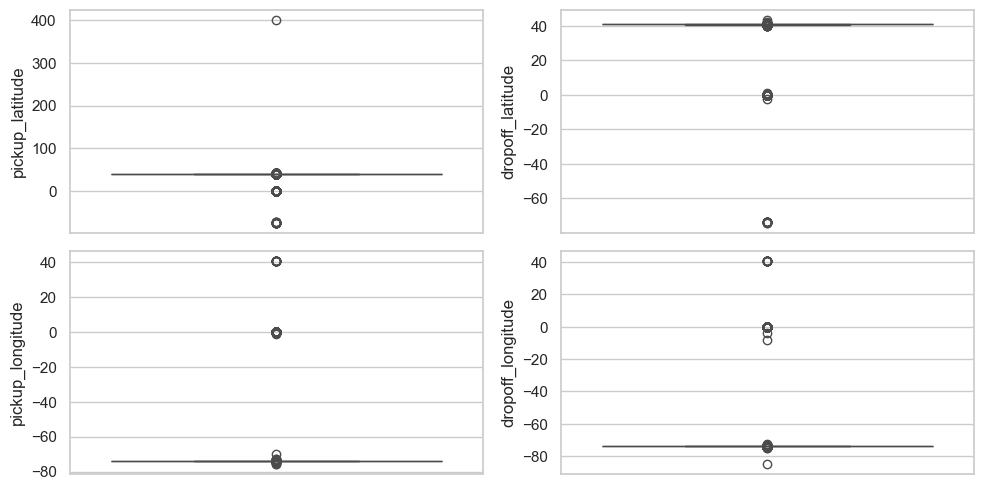

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=2)
sns.boxplot(nyc.pickup_latitude, ax = axes.flatten()[0])
sns.boxplot(nyc.dropoff_latitude, ax = axes.flatten()[1])
sns.boxplot(nyc.pickup_longitude, ax = axes.flatten()[2])
sns.boxplot(nyc.dropoff_longitude, ax = axes.flatten()[3])
plt.tight_layout()

Filter the available data and finally find the longest trip.

In [19]:
nyc_filtered = (nyc
                .query('(10 < pickup_latitude < 120) and (pickup_longitude < -60) and (10 < dropoff_latitude) and (dropoff_longitude < -60) and (distance < 50)')
                .reset_index(drop=True)
               )

In [20]:
longest = nyc_filtered.distance.idxmax()
longest

32795

In [21]:
nyc_filtered.loc[longest].fare_amount

136.0